In [1]:
#!/usr/bin/python

import pandas as pd
import numpy as np
import helper
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [2]:
IMAGES = '../images/'
DATA   = '../data/'

----

In [3]:
#############################
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# features_list = ['poi','salary'] # You will need to use more features
payment_features = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 'other', 'expenses', 'director_fees', 'total_payments']
stock_features   = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
mail_features    = ['from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']
extra_features   = ['bonus_deferral_payments_rate', 'rest_stock_deferral_payments_rate', 'exer_stock_options_deferral_payments_rate',
                    'long_term_incentive_total_payments_rate', 'bonus_total_payments_rate', 'exer_stock_options_total_payments_rate',
                    'toPOI_rate', 'fromPOI_rate']
extra_finance    = ['bonus_deferral_payments_rate', 'rest_stock_deferral_payments_rate', 'exer_stock_options_deferral_payments_rate',
                    'long_term_incentive_total_payments_rate', 'bonus_total_payments_rate', 'exer_stock_options_total_payments_rate']
extra_mail       = ['toPOI_rate', 'fromPOI_rate']
feature_list = payment_features + stock_features + mail_features + extra_features

In [4]:
### Load the dictionary containing the dataset
my_data = pd.read_pickle(DATA+"my_dataFrame.pkl")

In [5]:
my_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
poi,144.0,1.250000e-01,3.318733e-01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
salary,94.0,2.840875e+05,1.771311e+05,4.770000e+02,211802.000000,2.587410e+05,3.086065e+05,1.111258e+06
bonus,81.0,1.201773e+06,1.441679e+06,7.000000e+04,425000.000000,7.500000e+05,1.200000e+06,8.000000e+06
long_term_incentive,65.0,7.464912e+05,8.629174e+05,6.922300e+04,275000.000000,4.221580e+05,8.318090e+05,5.145434e+06
deferred_income,49.0,-5.712835e+05,9.347149e+05,-3.504386e+06,-583325.000000,-1.440620e+05,-3.834600e+04,-8.330000e+02
deferral_payments,37.0,8.671188e+05,1.297344e+06,7.961000e+03,85430.000000,2.274490e+05,8.753070e+05,6.426990e+06
other,90.0,4.700610e+05,1.404768e+06,2.000000e+00,1197.000000,3.857000e+04,3.440270e+05,1.035973e+07
expenses,96.0,5.453331e+04,4.671275e+04,1.480000e+02,22140.500000,4.654750e+04,7.925225e+04,2.287630e+05
director_fees,15.0,9.323447e+04,3.332008e+04,1.750000e+04,100017.000000,1.037500e+05,1.108950e+05,1.250340e+05
total_payments,123.0,2.516459e+06,9.455875e+06,1.480000e+02,377387.500000,1.099100e+06,2.064694e+06,1.035598e+08


----

In [6]:
### Extract features and labels from dataset for local testing
# data = featureFormat(my_dataset, features_list, sort_keys = True)
# labels, features = targetFeatureSplit(data)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Divide data into features and labels 
y = my_data['poi'].copy().astype(np.int)
X = my_data[feature_list].copy()

In [9]:
# Split data into training and test set using stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=77, stratify=y) 

In [10]:
# I spare 25% of the data as test set to have at least 5 'poi's in the test set. It's important to me to realize a high recall value, identifying as many 'poi's as possible.  
print "Number of POIs in the test set:" , y_test.sum()

Number of POIs in the test set: 5


In [11]:
# Save the order of insiders
insiders_train = y_train.index
insiders_test  = y_test.index

In [38]:
# Dealing with missing values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [13]:
impute_01 = ColumnTransformer(
     [('finance_data',  SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), payment_features+stock_features),
      ('mail_data',     SimpleImputer(missing_values=np.nan, strategy='median'), mail_features),
      ('extra_finance', SimpleImputer(missing_values=np.nan, strategy='median'), extra_finance),
      ('extra_mail',    SimpleImputer(missing_values=np.nan, strategy='median'), extra_mail)],
     remainder='passthrough')

In [14]:
# XXX_train = impute.fit_transform(X_train)
# XXX_train_df = pd.DataFrame(XXX_train, columns=feature_list, index=insiders_train )
# XXX_train_df.head().transpose()

'''
def impute_data(X):
    imp_Zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0)
    imp_Median = SimpleImputer(missing_values=np.nan, strategy='median')
    
    finance_data = imp_Zero.fit_transform(X[:,:13])
    mail_data    = imp_Median.fit_transform(X[:,13:16])
    extra_data   = imp_Median.fit_transform(X[:,16:])
    
    return np.concatenate((finance_data, mail_data, extra_data), axis=1) 

impute_01 = FunctionTransformer(impute_data, validate=False)
'''

In [23]:
pipe_01 = Pipeline([ ('impute', impute_01), ('scale', RobustScaler()) ])
pipe_02 = Pipeline([ ('impute', impute_01), ('scale', StandardScaler()) ])

In [16]:
pipe_01.fit(X_train)

Pipeline(memory=None,
     steps=[('impute', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('finance_data', SimpleImputer(copy=True, fill_value=0.0, missing_values=nan,
       strategy='constant', verbose=0), ['salary', 'bonus', 'long_te...obustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True))])

In [17]:
X_train_scale = pipe_01.transform(X_train)

In [18]:
X_train_scale_df = pd.DataFrame(X_train_scale, columns=feature_list, index=insiders_train)

In [19]:
X_train_scale_df.head().transpose()

,SKILLING JEFFREY K,DERRICK JR. JAMES V,WHITE JR THOMAS E,MENDELSOHN JOHN,LOWRY CHARLES P
salary,3.280906,1.005751e+00,0.363029,-0.804331,-0.804331
bonus,6.235294,5.882353e-01,0.176471,-0.352941,-0.352941
long_term_incentive,4.124183,1.039638e+00,0.000000,0.000000,0.000000
deferred_income,0.000000,-2.251387e+01,0.000000,-1.819170,0.000000
deferral_payments,0.000000,0.000000e+00,0.000000,0.000000,0.000000
other,0.261616,8.063270e-02,13.406891,-0.011862,-0.011862
expenses,0.044862,4.338225e-01,0.973472,-0.476203,-0.478845
director_fees,0.000000,0.000000e+00,0.000000,103750.000000,0.000000
total_payments,4.312816,-2.174852e-01,0.553214,-0.524362,-0.524444
exercised_stock_options,10.622537,4.689839e+00,0.399024,-0.339595,-0.127639


In [30]:
X_train_scale_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
salary,108.0,-0.091053,0.722695,-8.043310e-01,-0.804331,0.0,0.195669,3.280906
bonus,108.0,0.478267,1.519166,-3.529412e-01,-0.352941,0.0,0.647059,9.058824
long_term_incentive,108.0,0.853974,1.640734,0.000000e+00,0.000000,0.0,1.000000,11.052454
deferred_income,108.0,-3.406639,10.269539,-6.144650e+01,-1.000000,0.0,0.000000,0.000000
deferral_payments,108.0,15.049916,43.855621,0.000000e+00,0.000000,0.0,1.000000,250.364715
other,108.0,3.241987,13.441656,-1.186157e-02,-0.011862,0.0,0.988138,128.057577
expenses,108.0,0.194416,0.842233,-4.788453e-01,-0.478845,0.0,0.521155,3.605041
director_fees,108.0,10568.472222,32328.745764,0.000000e+00,0.000000,0.0,0.000000,125034.000000
total_payments,108.0,0.785936,5.568750,-5.244443e-01,-0.474197,0.0,0.525803,57.170143
exercised_stock_options,108.0,0.947974,3.051846,-3.395949e-01,-0.339595,0.0,0.660405,19.220484


In [20]:
from helper import crt_plot

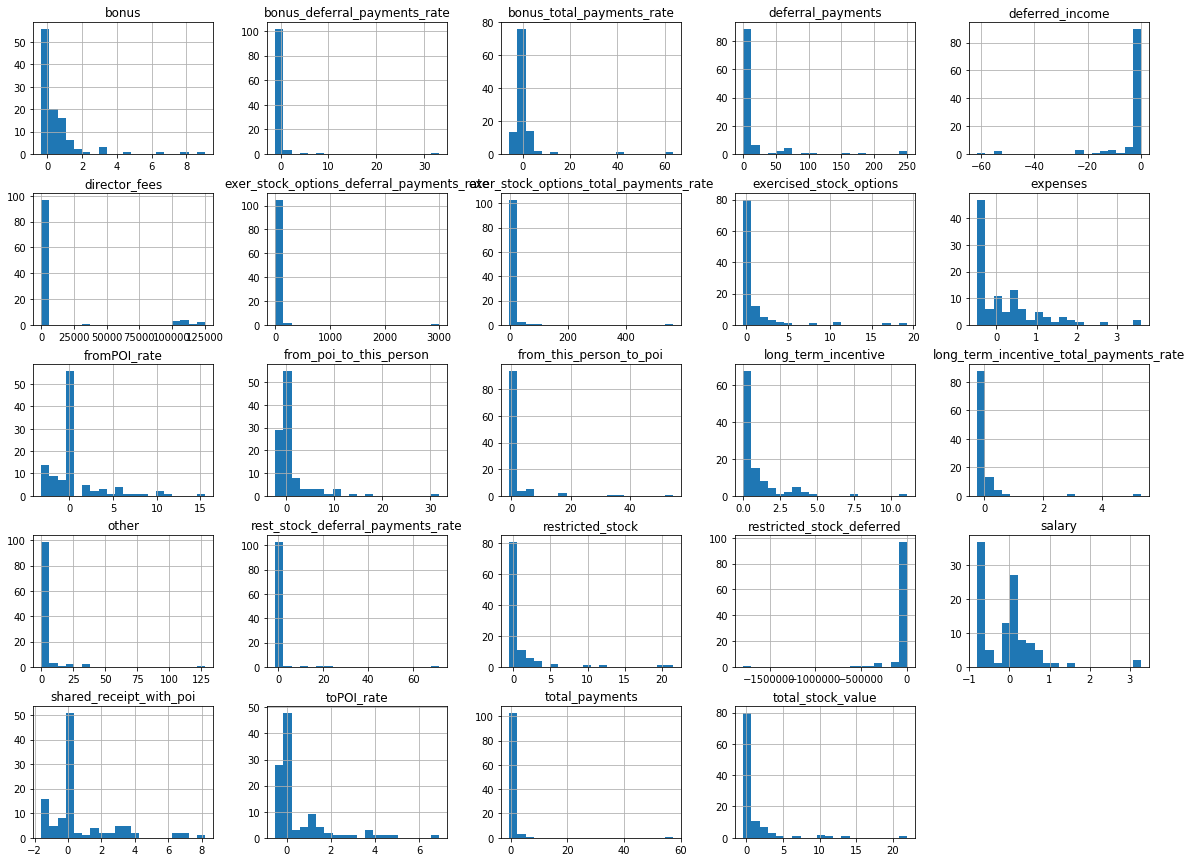

In [37]:
X_train_scale_df.hist(bins=20, figsize=(20,15));

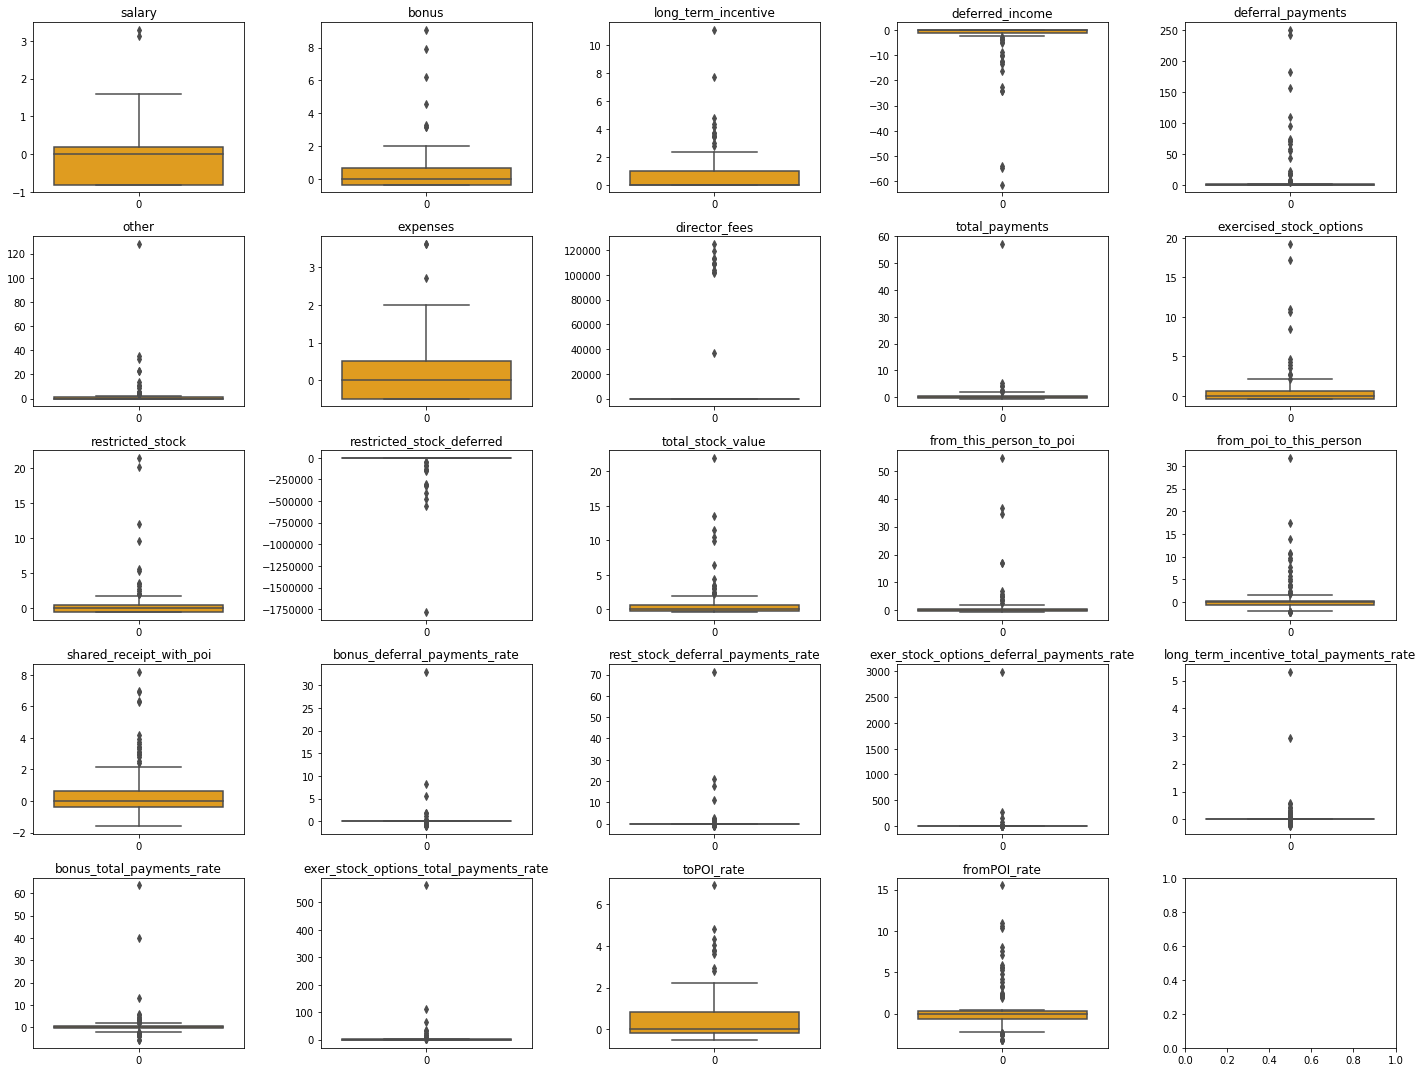

In [22]:
crt_plot(X_train_scale_df, feature_list, shape=(5,5), bins=20, sort=False)

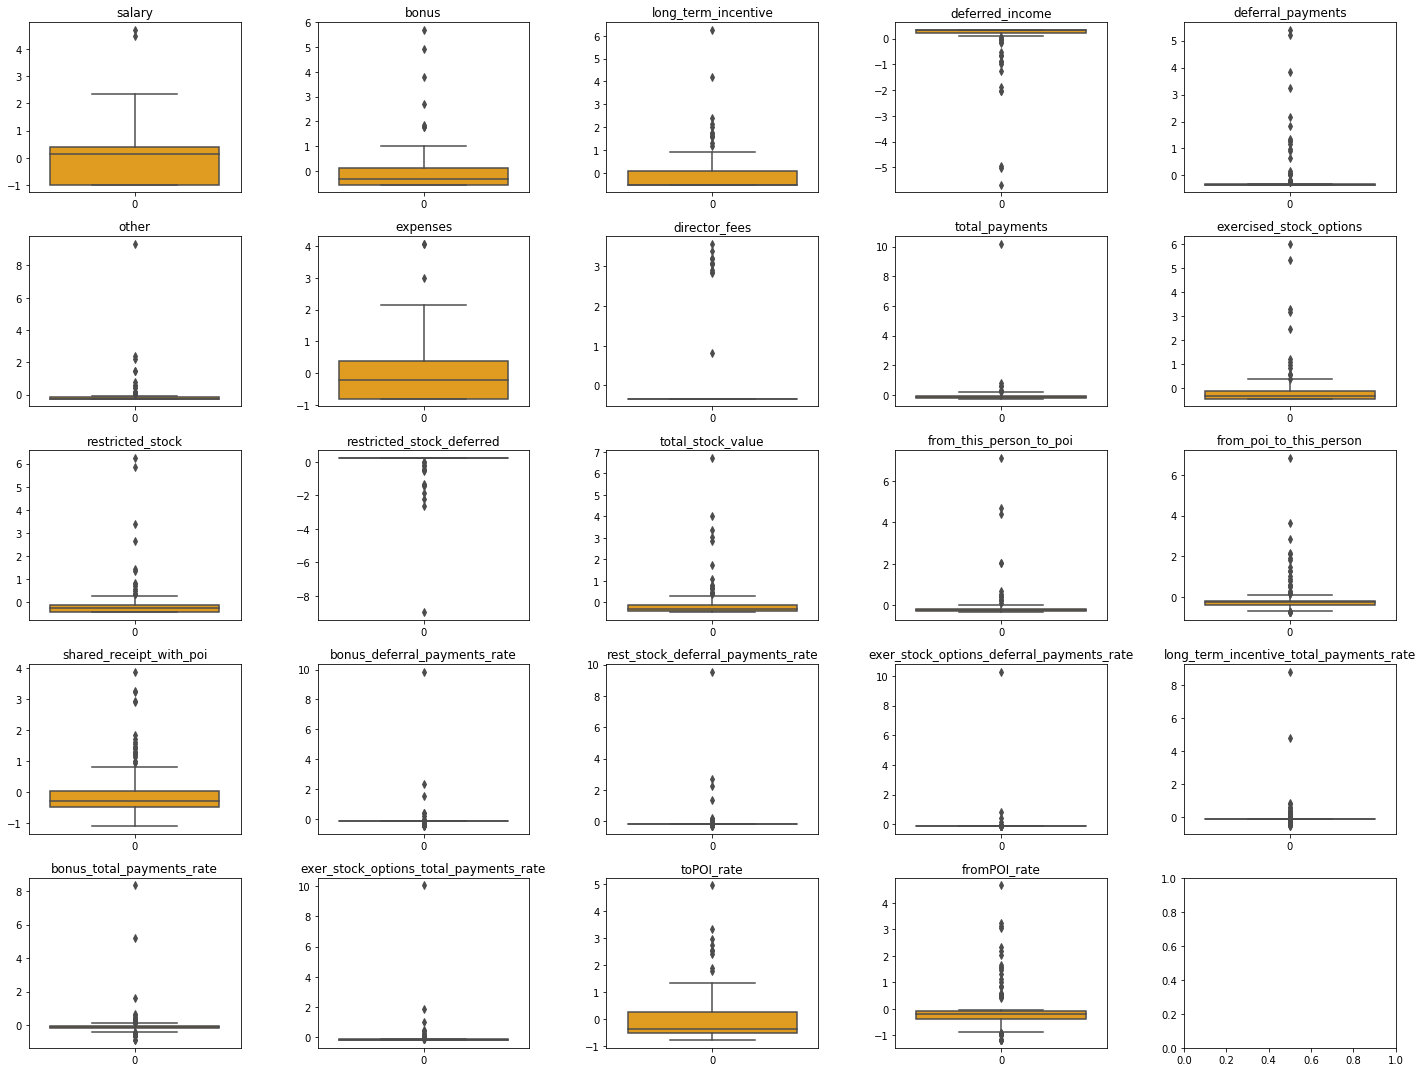

In [25]:
pipe_02.fit(X_train)
X_train_scale_02 = pipe_02.transform(X_train)
X_train_scale_02_df = pd.DataFrame(X_train_scale_02, columns=feature_list, index=insiders_train)
crt_plot(X_train_scale_02_df, feature_list, shape=(5,5), bins=20, sort=False)

In [31]:
X_train_scale_02_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
salary,108.0,-7.607084e-17,1.004662,-0.991572,-0.991572,0.126578,0.398589,4.687567
bonus,108.0,8.532270e-17,1.004662,-0.549698,-0.549698,-0.316289,0.111626,5.674534
long_term_incentive,108.0,-4.728728e-17,1.004662,-0.522910,-0.522910,-0.522910,0.089415,6.244783
deferred_income,108.0,-3.340949e-17,1.004662,-5.678000,0.235440,0.333269,0.333269,0.333269
deferral_payments,108.0,1.336380e-17,1.004662,-0.344769,-0.344769,-0.344769,-0.321861,5.390685
other,108.0,7.709882e-18,1.004662,-0.243201,-0.243201,-0.242314,-0.168458,9.329020
expenses,108.0,2.441463e-17,1.004662,-0.803103,-0.803103,-0.231910,0.389752,4.068382
director_fees,108.0,2.467162e-17,1.004662,-0.328430,-0.328430,-0.328430,-0.328430,3.557180
total_payments,108.0,2.698459e-17,1.004662,-0.236407,-0.227341,-0.141791,-0.046931,10.172313
exercised_stock_options,108.0,-1.747573e-17,1.004662,-0.423865,-0.423865,-0.312071,-0.094667,6.015276


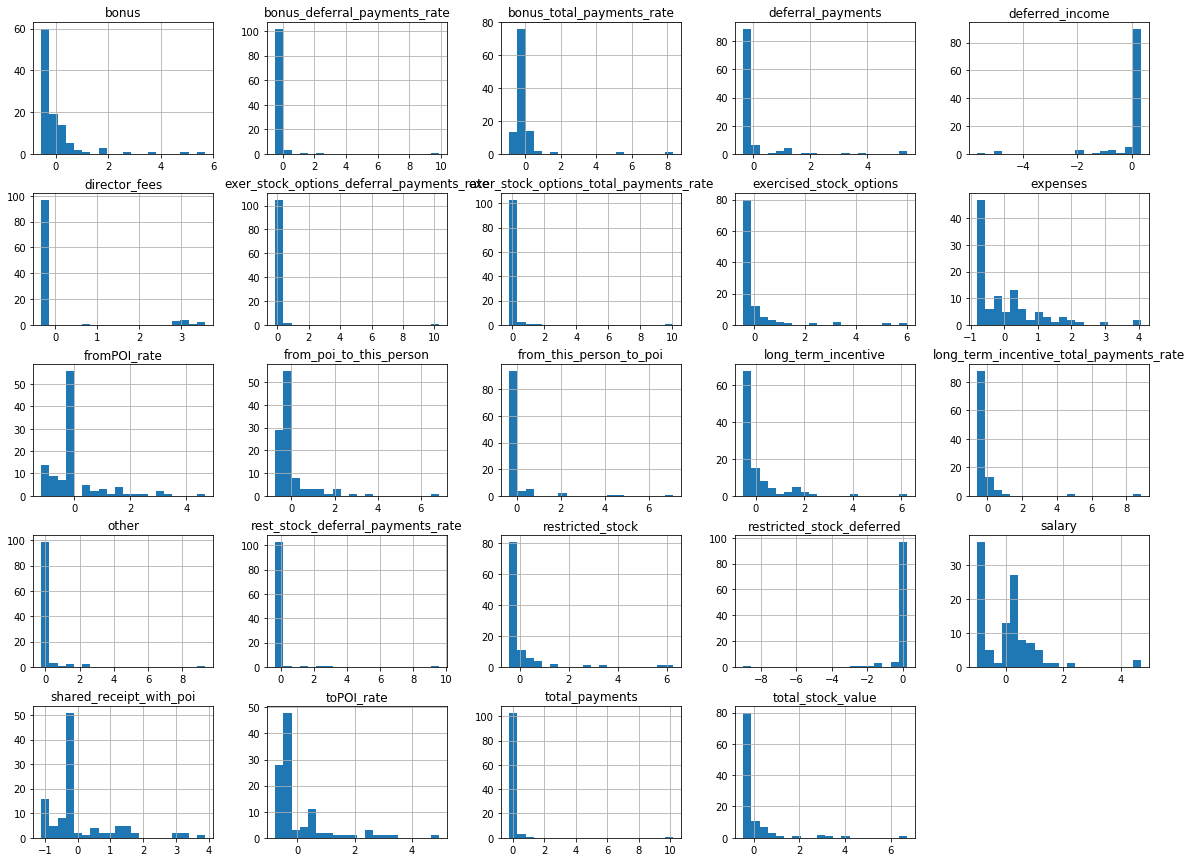

In [34]:
X_train_scale_02_df.hist(bins=20, figsize=(20,15));

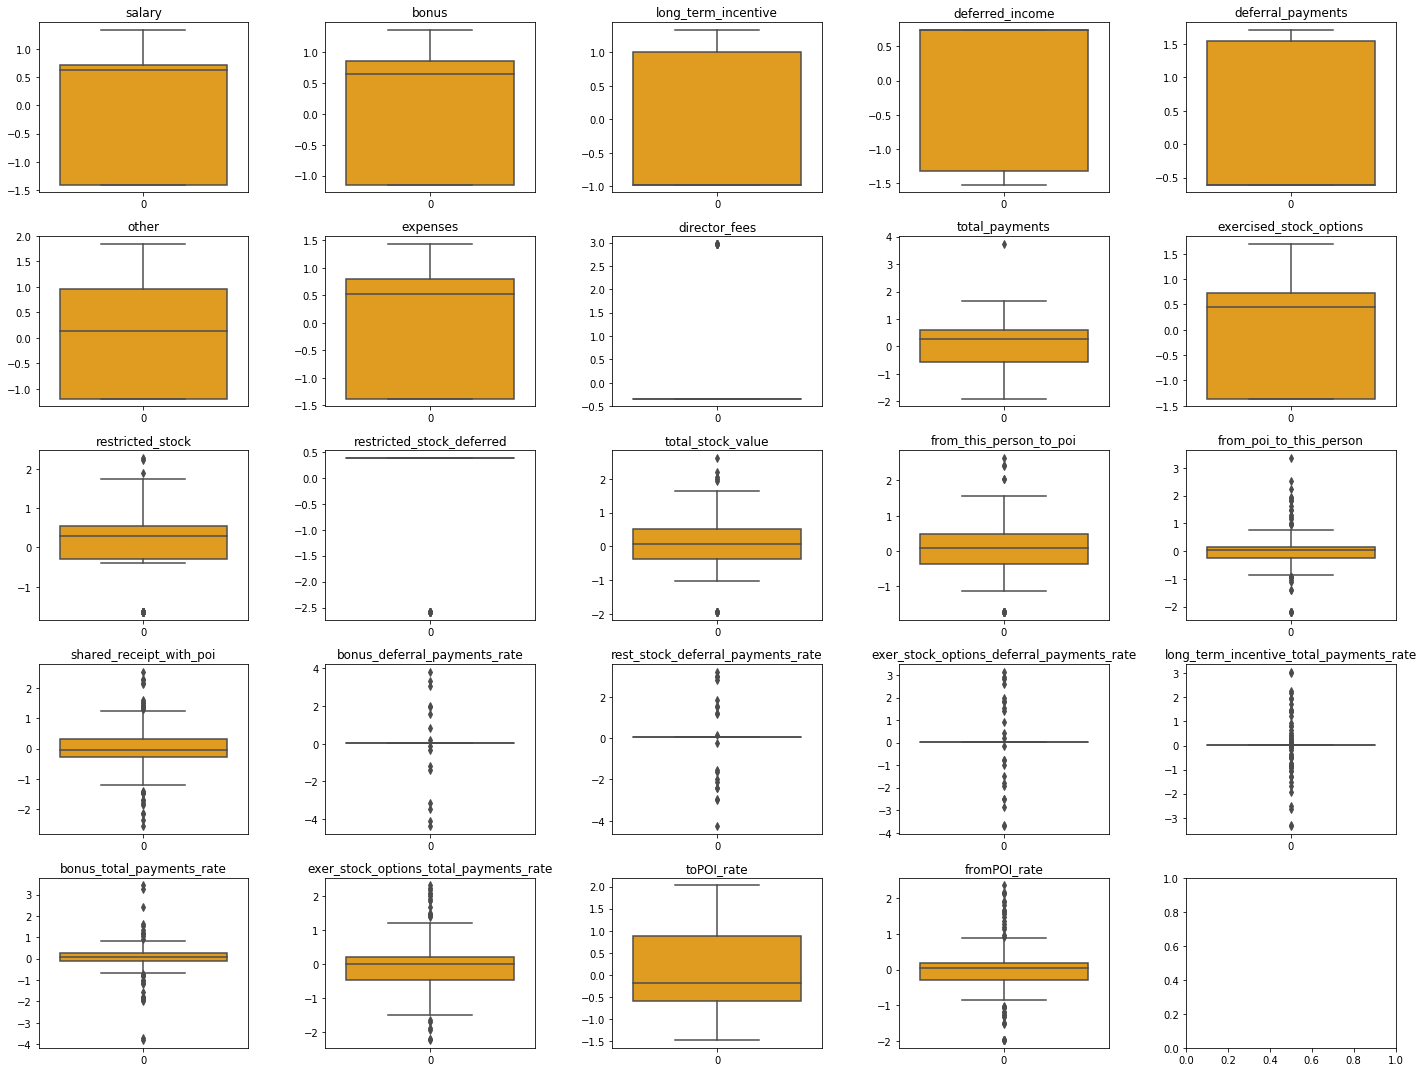

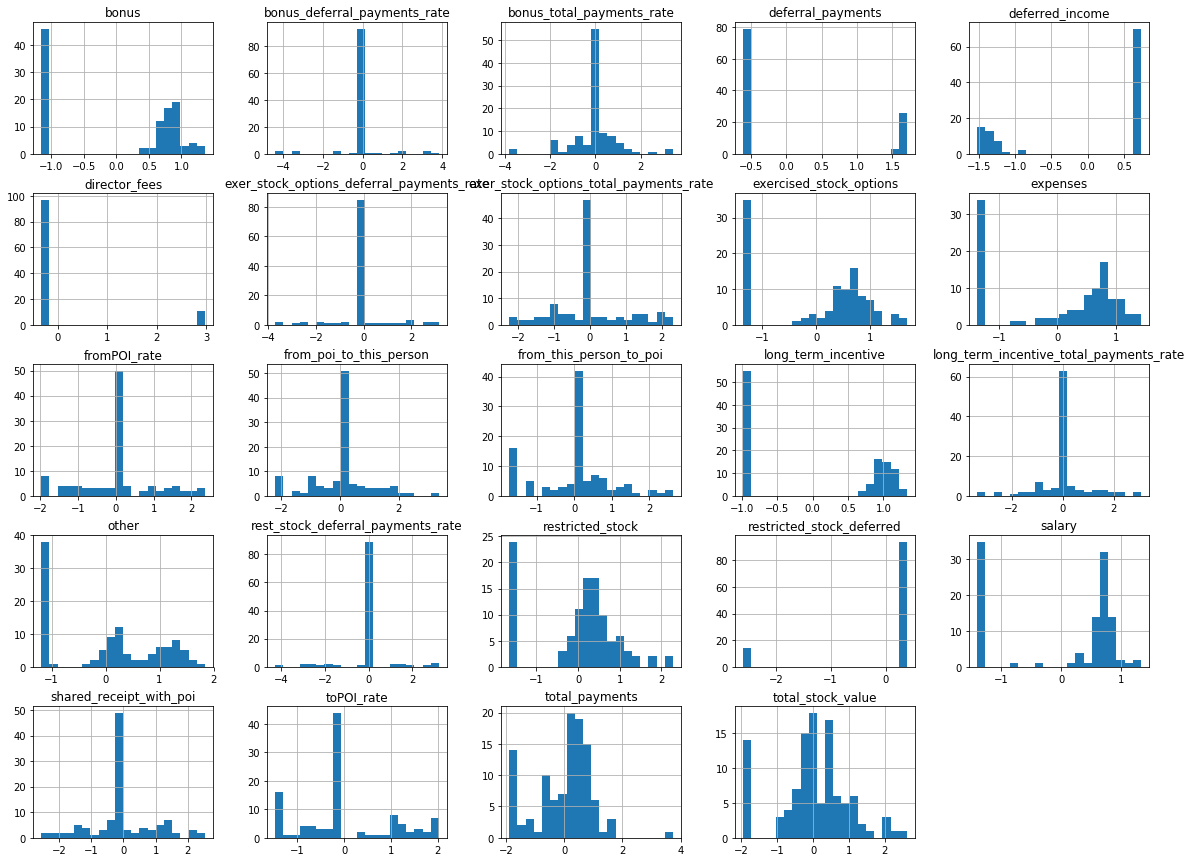

In [44]:
# Non-linear scaling with 'PowerTransformer'
pipe_03 = Pipeline([ ('impute', impute_01), ('scale', PowerTransformer(method='yeo-johnson')) ])
pipe_03.fit(X_train)
X_train_scale_03 = pipe_03.transform(X_train)
X_train_scale_03_df = pd.DataFrame(X_train_scale_03, columns=feature_list, index=insiders_train)
crt_plot(X_train_scale_03_df, feature_list, shape=(5,5), bins=20, sort=False)
X_train_scale_03_df.hist(bins=20, figsize=(20,15));

In [45]:
X_train_scale_03_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
salary,108.0,1.583096e-16,1.004662,-1.403719,-1.403719,0.632761,0.716293,1.331736
bonus,108.0,-6.167906e-17,1.004662,-1.149089,-1.149089,0.650881,0.862019,1.359112
long_term_incentive,108.0,2.138207e-16,1.004662,-0.977172,-0.977172,-0.977172,1.005893,1.330770
deferred_income,108.0,-1.027984e-16,1.004662,-1.518284,-1.312593,0.734311,0.734311,0.734311
deferral_payments,108.0,3.906340e-17,1.004662,-0.605696,-0.605696,-0.605696,1.542792,1.704024
other,108.0,-1.912051e-16,1.004662,-1.191024,-1.191024,0.137998,0.963319,1.840517
expenses,108.0,7.709882e-17,1.004662,-1.374704,-1.374704,0.517279,0.798926,1.430902
director_fees,108.0,0.000000e+00,1.004662,-0.336752,-0.336752,-0.336752,-0.336752,2.969583
total_payments,108.0,-7.195890e-18,1.004662,-1.895991,-0.582368,0.267960,0.603624,3.734219
exercised_stock_options,108.0,3.700743e-17,1.004662,-1.356368,-1.356368,0.453020,0.735340,1.692899


----

In [46]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

In [47]:
# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [55]:
clf.fit(X_train_scale_02, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [56]:
clf.score(X_train_scale_02, y_train)

0.8240740740740741

In [ ]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

In [ ]:
# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)
'''